In [9]:
import matplotlib.pyplot as plt
from glob import glob
from deepforest import main
import cv2
import os
from PIL import Image
import numpy as np

In [93]:
forest = 'forest4'

In [4]:
vidcap = cv2.VideoCapture('./{}/forest.mp4'.format(forest))

success,image = vidcap.read()
count = 0
if not os.path.exists('./{}/frames'.format(forest)):
  os.mkdir('./{}/frames'.format(forest))
  while success:
    cv2.imwrite("./{}/frames/frame{}.jpg".format(forest, count), image)     # save frame as JPEG file      
    success,image = vidcap.read()
    count += 1

In [91]:
stitcher = cv2.Stitcher_create(cv2.Stitcher_SCANS)

if not os.path.exists('./{}/stitch.jpg'.format(forest)):
    images = []
    for filename in os.listdir('./{}/frames'.format(forest)):
        img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
        
        scale_percent = 60 # percent of original size
        width = int(img.shape[1] * scale_percent / 100)
        height = int(img.shape[0] * scale_percent / 100)
        dim = (width, height)
        images.append(cv2.resize(img, dim)) 
    result = stitcher.stitch(images)
    print(result[0])

    cv2.imwrite('./{}/stitch.jpg'.format(forest), result[1])

AttributeError: 'NoneType' object has no attribute 'shape'

In [89]:
result = cv2.imread("./{}/stitch.jpg".format(forest))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

error: OpenCV(4.5.4-dev) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


Reading config file: /usr/local/lib/python3.9/site-packages/deepforest/data/deepforest_config.yml
Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/1.0.0 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


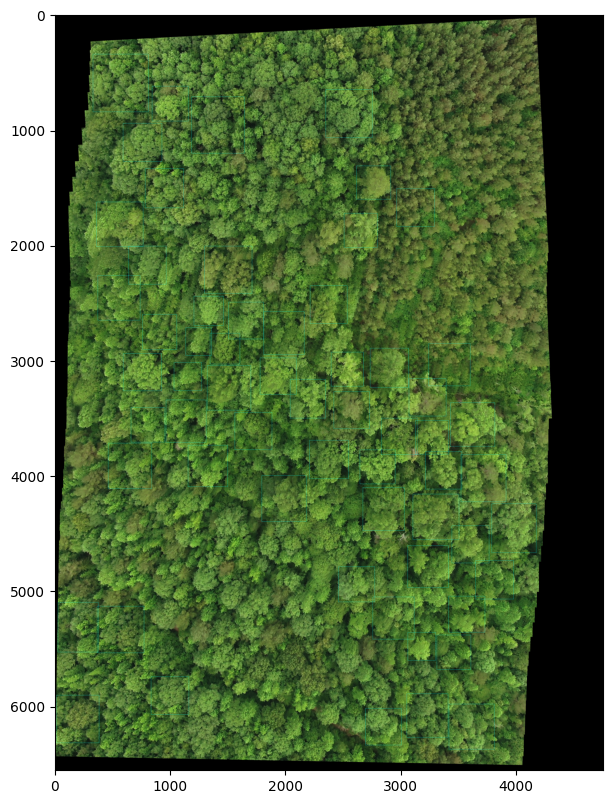

In [113]:
model = main.deepforest()
model.use_release()

plt.figure(figsize=(15, 10), dpi=100)
img = model.predict_image(path="./{}/stitch.jpg".format(forest), return_plot=True)
frame = model.predict_image(path="./{}/stitch.jpg".format(forest))

#predict_image returns plot in BlueGreenRed (opencv style), but matplotlib likes RedGreenBlue, switch the channel order.
plt.imshow(img[:,:,::-1])
plt.show()

In [8]:
inchesPerPixel = 0.075
heightInInches = 15 

total_lbs = 0
for i, row in frame.iterrows():
    diameter = min(row['xmax'] - row['xmin'], row['ymax'] - row['ymin']) * inchesPerPixel
    weight = 0.25 * pow(diameter, 2) * heightInInches
    green_weight = weight * 1.20
    dry_weight = green_weight * 0.725
    lbs_carbon = dry_weight * 0.50
    lbs_co2 = lbs_carbon * 3.6663
    lbs_co2_per_year = lbs_co2 / 10
    total_lbs = total_lbs + lbs_co2_per_year
total_tons = total_lbs / 2204.62
print("Metric tons per year of CO2 sequestered per year", total_tons)
print("Total tax credits for trees in video per year", "$" + str(round(total_tons * 50, 2)))

Metric tons per year of CO2 sequestered per year 0.5456835850349033
Total tax credits for trees in video per year $27.28


In [140]:
def getDisparityBetweenFrames(path1, path2):
    imgL = cv2.cvtColor(cv2.imread(path1), cv2.COLOR_BGR2RGB)
    imgR = cv2.cvtColor(cv2.imread(path2), cv2.COLOR_BGR2RGB)
    grayL = cv2.cvtColor(imgL, cv2.COLOR_RGB2GRAY)
    grayR = cv2.cvtColor(imgR, cv2.COLOR_RGB2GRAY)
    plt.imshow(grayL, 'gray')

    stereo = cv2.StereoBM_create(numDisparities=16, blockSize=5)
    return stereo.compute(grayL, grayR)

AttributeError: 'cv2.StereoBM' object has no attribute 'setSpeckleWindow'

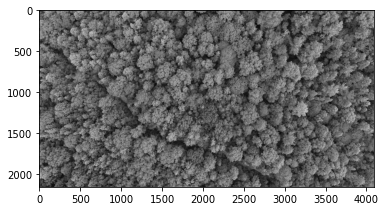

In [139]:

plt.imshow(getDisparityBetweenFrames("./{}/frames/frame0.jpg".format(forest), "./{}/frames/frame10.jpg".format(forest)),'gray')
plt.show()

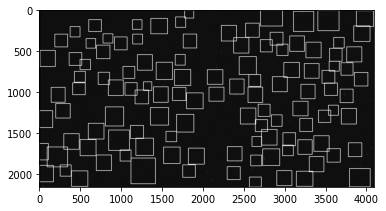

In [129]:
frame = model.predict_image(path="./{}/frames/frame0.jpg".format(forest))

for index, row in frame.iterrows():
    if row.label == "Tree":
        disparity = cv2.rectangle(disparity, (int(row.xmin), int(row.ymin)), (int(row.xmax), int(row.ymax)), color=(255, 255, 255), thickness=5)

plt.imshow(disparity, 'gray')

In [130]:
def get_average_height_of_frame(frame, disparity):
    heights = np.array([])
    for _, row in frame.iterrows():
        if row.label == "Tree":
            tree_section = disparity[int(row.xmin):int(row.xmax), int(row.ymin):int(row.ymax)]
            if (len(tree_section) > 0):
                max_height = np.unravel_index(np.argmax(tree_section), tree_section.shape)
                heights = np.append(heights, max_height)
    return np.mean(heights)

In [131]:
get_average_height_of_frame(frame, disparity)

42.8859649122807

inf 1.2857142857142858


/var/folders/r0/jfp3j1px1zd11ryl8rg7k96h0000gn/T/ipykernel_68191/589858838.py:8: RuntimeWarning: divide by zero encountered in true_divide
  calibration_ratio = np.abs(calibration_height / disparity[calibration_point])


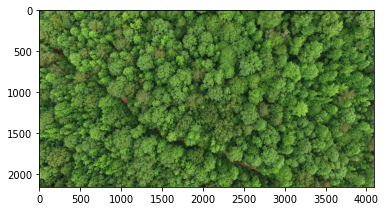

In [137]:
calibration_point = (220, 470) # should be set through a gui
calibration_line = [np.array((650, 580)), np.array((790, 580))]
calibration_height = 2040 # in inches 
calibration_length = 180
calibration_image = cv2.cvtColor(cv2.imread('./{}/frames/frame0.jpg'.format(forest)), cv2.COLOR_BGR2RGB)
calibration_image = cv2.circle(calibration_image, calibration_point, 5, color=(255, 0, 0), thickness=5)
calibration_image = cv2.line(calibration_image, calibration_line[0], calibration_line[1], color=(255,0,0), thickness=2)
calibration_ratio = np.abs(calibration_height / disparity[calibration_point])
distance_per_pixel = 180 / np.linalg.norm(calibration_line[0] - calibration_line[1])
print(calibration_ratio, distance_per_pixel)
plt.imshow(calibration_image)

In [133]:
def convert_disparity_value_to_inches(disparity_value, calibration_ratio):
    return disparity_value * calibration_ratio

In [135]:
def get_average_height_of_tree(calibration_ratio):
    heights = []
    number_of_frames = len(os.listdir('./{}/frames'.format(forest)))
    for i in range(0, number_of_frames, 10):
        frameA = "./{}/frames/frame{}.jpg".format(forest, i)
        frameB = "./{}/frames/frame{}.jpg".format(forest, i + 10)
        treeFrame = model.predict_image(path=frameA)
        disparity = getDisparityBetweenFrames(frameA, frameB)
        average_frame_height = get_average_height_of_frame(treeFrame, disparity)
        height_in_inches = convert_disparity_value_to_inches(average_frame_height, calibration_ratio)
        print("Average height for frame {} is {}in".format(i, height_in_inches))
        heights = np.append(heights, height_in_inches)
        
    return np.mean(heights)


Average height for frame 0 is infin
Average height for frame 10 is infin
Average height for frame 20 is infin


KeyboardInterrupt: 

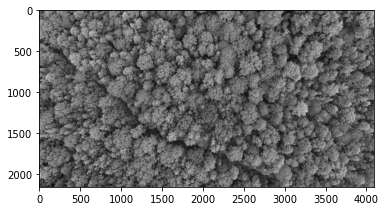

In [136]:
average_height = get_average_height_of_tree(calibration_ratio)

In [ ]:

def print_summary(average_tree_height_in_inches, distance_per_pixel, stitched_tree_frame):
    tree_trunk_ratio = 0.0625
    total_lbs = 0
    for _, row in stitched_tree_frame.iterrows():
        diameter = min(row['xmax'] - row['xmin'], row['ymax'] - row['ymin']) * tree_trunk_ratio * distance_per_pixel 
        weight = 0.25 * pow(diameter, 2) * (average_tree_height_in_inches / 12)
        green_weight = weight * 1.20
        dry_weight = green_weight * 0.725
        lbs_carbon = dry_weight * 0.50
        lbs_co2 = lbs_carbon * 3.6663
        lbs_co2_per_year = lbs_co2 / 10
        total_lbs = total_lbs + lbs_co2_per_year
    total_tons = total_lbs / 2204.62
    print("Metric tons per year of CO2 sequestered per year", total_tons)
    print("Total tax credits for trees in video per year", "$" + str(round(total_tons * 50, 2)))

In [209]:
print_summary(average_height, distance_per_pixel, frame)

Metric tons per year of CO2 sequestered per year 5.812534690466642
Total tax credits for trees in video per year $290.63


In [166]:
import matplotlib.pyplot as plt
from glob import glob
from deepforest import main
import cv2
import os
from PIL import Image
import numpy as np

def calculate_CO2_sequestered_in_video(path_to_video_directory, calibration_parameters):
    model = main.deepforest()
    model.use_release()
    write_frames_to_dir(path_to_video_directory)
    stitch_path = stitch_frames(path_to_video_directory)
    stitch_data_frame = get_stitch_frame(stitch_path, model)
    calibration_ratio, distance_per_pixel = calibrate(path_to_video_directory, calibration_parameters)
    average_height = get_average_height_of_tree(path_to_video_directory, calibration_ratio, model)
    total_tons = calculate_total_co2_sequestered(average_height, distance_per_pixel, stitch_data_frame)
    print("Metric tons per year of CO2 sequestered per year", total_tons)
    print("Total tax credits for trees in video per year", "$" + str(round(total_tons * 50, 2)))
    plt.imshow(cv2.cvtColor(cv2.imread(stitch_path), cv2.COLOR_BGR2RGB))
    

def write_frames_to_dir(video_directory):
    vidcap = cv2.VideoCapture('{}/forest.mp4'.format(video_directory))
    frames_path = '{}/frames'.format(video_directory)

    success,image = vidcap.read()
    count = 0
    if not os.path.exists(frames_path):
        os.mkdir(frames_path)
        while success:
            cv2.imwrite("{}/frame{}.jpg".format(frames_path, count), image)     # save frame as JPEG file      
            success,image = vidcap.read()
            count += 1

def stitch_frames(video_path):
    stitcher = cv2.Stitcher_create(cv2.Stitcher_SCANS)
    stitch_path = '{}/stitch.jpg'.format(video_path)

    if not os.path.exists(stitch_path):
        images = []
        filenames = get_frames_in_order(video_path)
        for i in range(0, len(filenames), 10): 
            filename = filenames[i]
            img = cv2.imread('{}/frames/{}'.format(video_path, filename), cv2.IMREAD_UNCHANGED)
            
            scale_percent = 100 # percent of original size
            width = int(img.shape[1] * scale_percent / 100)
            height = int(img.shape[0] * scale_percent / 100)
            dim = (width, height)
            images.append(cv2.resize(img, dim)) 
        result = stitcher.stitch(images)

        cv2.imwrite(stitch_path, result[1])
    return stitch_path

def get_frames_in_order(video_path):
    filenames = os.listdir('{}/frames'.format(video_path))
    frameIds = [int(x.replace("frame", "").replace(".jpg", "")) for x in filenames]
    frameIds.sort()
    return ["frame{}.jpg".format(x) for x in frameIds] 

def get_stitch_frame(stitch_path, model):
    return model.predict_image(path=stitch_path)

def calibrate(video_path, calibration_parameters):
    disparity = get_disparity_between_frames('{}/frames/frame0.jpg'.format(video_path), '{}/frames/frame1.jpg'.format(video_path)) 
    calibration_point, calibration_line, calibration_height, calibration_length = calibration_parameters
    calibration_ratio = np.abs(calibration_height / disparity[calibration_point[1], calibration_point[0]])
    distance_per_pixel = calibration_length / np.linalg.norm(calibration_line[0] - calibration_line[1])
    return (calibration_ratio, distance_per_pixel)
    
def get_average_height_of_tree(video_directory, calibration_ratio, model):
    heights = []
    number_of_frames = len(os.listdir('{}/frames'.format(video_directory)))
    for i in range(0, number_of_frames, 10):
        frameA = "{}/frames/frame{}.jpg".format(video_directory, i)
        frameB = "{}/frames/frame{}.jpg".format(video_directory, i + 1)
        if i + 1 < number_of_frames:
            treeFrame = model.predict_image(path=frameA)
            disparity = get_disparity_between_frames(frameA, frameB)
            average_frame_height = get_average_height_of_frame(treeFrame, disparity)
            height_in_inches = convert_disparity_value_to_inches(average_frame_height, calibration_ratio)
            heights = np.append(heights, height_in_inches)
    return np.mean(heights)

def get_disparity_between_frames(path1, path2):
    imgL = cv2.cvtColor(cv2.imread(path1), cv2.COLOR_BGR2RGB)
    imgR = cv2.cvtColor(cv2.imread(path2), cv2.COLOR_BGR2RGB)
    grayL = cv2.cvtColor(imgL, cv2.COLOR_RGB2GRAY)
    grayR = cv2.cvtColor(imgR, cv2.COLOR_RGB2GRAY)
    stereo = cv2.StereoBM_create(numDisparities=16, blockSize=5)
    return stereo.compute(grayL, grayR)

def get_average_height_of_frame(frame, disparity):
    heights = np.array([])
    for _, row in frame.iterrows():
        if row.label == "Tree":
            tree_section = disparity[int(row.xmin):int(row.xmax), int(row.ymin):int(row.ymax)]
            if (len(tree_section) > 0):
                max_height = np.unravel_index(np.argmax(tree_section), tree_section.shape)
                heights = np.append(heights, max_height)
    return np.mean(heights)
    
def convert_disparity_value_to_inches(disparity_value, calibration_ratio):
    return disparity_value * calibration_ratio

def calculate_total_co2_sequestered(average_tree_height_in_inches, distance_per_pixel, stitched_tree_frame):
    tree_trunk_ratio = 0.0625
    total_lbs = 0
    for _, row in stitched_tree_frame.iterrows():
        diameter = min(row['xmax'] - row['xmin'], row['ymax'] - row['ymin']) * tree_trunk_ratio * distance_per_pixel 
        weight = 0.25 * pow(diameter, 2) * (average_tree_height_in_inches / 12)
        green_weight = weight * 1.20
        dry_weight = green_weight * 0.725
        lbs_carbon = dry_weight * 0.50
        lbs_co2 = lbs_carbon * 3.6663
        lbs_co2_per_year = lbs_co2 / 10
        total_lbs = total_lbs + lbs_co2_per_year
    return total_lbs / 2204.62

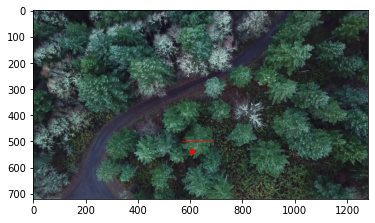

In [200]:

forest = 'forest4'
disparity = get_disparity_between_frames('./{}/frames/frame0.jpg'.format(forest), './{}/frames/frame1.jpg'.format(forest)) 
calibration_point = (610, 540) # should be set through a gui
calibration_line = [np.array((570, 500)), np.array((690, 500))]
calibration_height = 960 # in inches 
calibration_length = 120
calibration_image = cv2.cvtColor(cv2.imread('./{}/frames/frame0.jpg'.format(forest)), cv2.COLOR_BGR2RGB)
calibration_image = cv2.circle(calibration_image, calibration_point, 5, color=(255, 0, 0), thickness=10)
disparity_image = cv2.circle(disparity, calibration_point, 5, color=(255, 0, 0), thickness=10)
calibration_image = cv2.line(calibration_image, calibration_line[0], calibration_line[1], color=(255,0,0), thickness=2)
plt.imshow(calibration_image)
# plt.imshow(disparity_image, 'gray')

Reading config file: /usr/local/lib/python3.9/site-packages/deepforest/data/deepforest_config.yml
Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/1.0.0 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0
Metric tons per year of CO2 sequestered per year 7.526098229594391
Total tax credits for trees in video per year $376.3


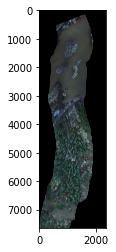

In [201]:
calibration_parameters = (calibration_point, calibration_line, calibration_height, calibration_length)
calculate_CO2_sequestered_in_video('./forest4', calibration_parameters)